In [1]:
import numpy as np
import re
print(np.__version__)
import os
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from tensorflow.keras import datasets, layers, models 
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')

import sklearn as sk
from sklearn.model_selection import train_test_split
from data_split import data_separator, get_oversampling
from data_loader import load_and_preprocess_image, generate_path_dataset, augmenter
from model_creation import start_model, set_check_poin_saver, set_check_point_saver_regression
from model_evaluation import plot_model_history, get_dataset_prediction, evaluate_prediction

1.23.5


2023-12-22 14:13:31.978840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 14:13:32.168672: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 14:13:32.838598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/12559743/.local/lib/python3.10/site-packages/cv2/../../lib64::/opt/Qt/6.3.1/gcc_6/lib:/home/12559743/miniconda3/envs/tensorflow/lib/
2023-12-22 14:13:32.838738: W tensorflow/stream_executor/platform

2.10.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)])
  except RuntimeError as e:
      print(e)

In [3]:
!nvidia-smi

/bin/bash: /home/12559743/miniconda3/envs/tensorflow/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Fri Dec 22 14:13:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P5000                   Off | 00000000:3B:00.0 Off |                  Off |
| 26%   36C    P5              11W / 180W |     27MiB / 16384MiB |      0%      Default |
|                            

In [4]:
df = pd.read_csv('data_aug.csv')
#del df['Unnamed: 0']
#df = df.sample(frac = 1, random_state=2023).reset_index(drop=True)
df = df.dropna(axis=0)
print(len(df))
df.head()

1046


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Patient,Sex,Date of birth,PAN Date,Age at PAN,PAN Path
0,0,0.0,0.0,SEBASTIAO ABAQUI,1,24/05/1943,25/10/2016,74.0,/home/12559743/DAVI/todos_pacientes/ABAQUI SEB...
1,1,1.0,1.0,ABEGAIR SOUZA SILVA,1,03/03/1981,28/09/2018,38.0,/home/12559743/DAVI/todos_pacientes/ABEGAIR SO...
2,2,2.0,2.0,ABEL GONCALVES DA CUNHA,1,01/03/1970,05/10/2016,47.0,/home/12559743/DAVI/todos_pacientes/ABEL GONÇA...
3,3,3.0,3.0,ABELARDO RODRIGUES DA SILVA,1,04/01/1977,13/11/2018,42.0,/home/12559743/DAVI/todos_pacientes/ABELARDO R...
4,4,4.0,4.0,JOSE BENEDITO DE ABREU,1,29/09/1938,13/04/2016,78.0,/home/12559743/DAVI/todos_pacientes/ABREU JOSE...


# Realizando o amento dos dados

In [10]:
filter_sex = df['Sex'] ==0

df_sex_fem = df[filter_sex]


PAN_Path_sex_fem = df_sex_fem['PAN Path'].tolist()

type(PAN_Path_sex_fem)

list

In [11]:
from PIL import Image

augment_factor = 1

for image_path in PAN_Path_sex_fem:
    image = Image.open(image_path)
    image = image.rotate(np.random.randint(0,90,1))
    for i in range(augment_factor):
        new_name = image_path.replace('_cr.jpg', 'aug_cr.jpg')
        new_df = pd.DataFrame({'PAN Path': new_name, 'Sex': [0] * len(PAN_Path_sex_fem)})

        image.save(new_name)
        print(f"{new_name} as append")

        
        
df_aug = pd.concat([df, new_df], ignore_index=True)

df_aug.to_csv('data_aug.csv')

/home/12559743/DAVI/todos_pacientes/ADELINA DE OLIVEIRA LEANDRO/ADELINA DE OLIVEIRA LEANDRO- -- - - - 18-10-1965- PX from 10-07-2019 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ADRIANA APARECIDA DOS SANTOS SANTANA/ADRIANA APARECIDA DOS S- SANT AN- -- - - - 28-01-1975- PX from 27-09-2016 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ADRIANA DA SILVA MOTA/ADRIANA DA SILVA MOTA- -- - - - 14-11-1971- PX from 08-08-2017 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ADRIANA DA SILVA MOTA/ADRIANA DA SILVA MOTA- -- - - - 14-11-1971- PX from 16-09-2016 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ADRIANA FERREIRA DE SOUZA/ADRIANA FERREIRA DE SOUZA- -- - - - 06-06-1974- PX from 07-03-2019 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ADRIANA MIGUEL DA SILVA/ADRIANA MIGUEL DA SILVA- -- - - - 04-08-1974- PX from 15-03-2016 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ADRIANA MIGUEL DA SILVA/ADRIANA 

/home/12559743/DAVI/todos_pacientes/ANA MARIA MARTINS SOARES NERES/ANA MARIA MARTINS SOARES NERES- -- - - - 24-11-1976- PX from 27-09-2017 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ANA MARIA PAULISTA/ANA MARIA PAULISTA- -- - - - 09-06-1962- PX from 01-10-2018 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ANA MARIA SOARES GABRIEL/ANA MARIA SOARES GABRIEL- -- - - - 16-06-1955- PX from 11-05-2015 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ANA NELIA COSTA BATISTA/ANA NELIA COSTA BATISTA- -- - - - 27-09-1976- PX from 08-08-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ANA PAULA AZEVEDO DOS SANTOS/ANA PAULA AZEVEDO DOS SANTOS- -- - - - 16-09-1976- PX from 05-12-2019 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ANA PAULA AZEVEDO DOS SANTOS/ANA PAULA AZEVEDO DOS SANTOS- -- - - - 16-09-1976- PX from 27-06-2019 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ANA PAULA DOS SANTOS/ANA P

/home/12559743/DAVI/todos_pacientes/BATISTA KAREN CRISTINA SILVA/KAREN CRISTINA SILVA BATISTA- -- - - - 01-01-1993- PX from 22-07-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/BEIRIGO DJALMA GONCALVES/DJALMA GONCALVES BEIRIGO- -- - - - 30-08-1940- PX from 18-02-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/BONFIM SONIA APARECIDA/SONIA APARECIDA BONFIM- -- - - - 08-11-1973- PX from 11-12-2014 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/BORGES MARIA ANESIA NOGUEIRA/MARIA ANESIA NOGUEIRA BORGES- -- - - - 06-08-1944- PX from 04-02-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/BRITO MARIA JOSE PEREIRA/MARIA JOSE PEREIRA BRITO- -- - - - 05-01-1951- PX from 03-05-2018 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/BUZALO ROSILDA MOREIRA/ROSILDA MOREIRA BUZALO- -- - - - 12-08-1962- PX from 13-06-2016 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/BUZALO ROSILDA MOREIRA/ROS

/home/12559743/DAVI/todos_pacientes/DIAS MARIA APARECIDA/MARIA APARECIDA DIAS- -- - - - 23-06-1964- PX from 23-11-2015 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/DIAS NEUCY DE OLIVEIRA/NEUCY DE OLIVEIRA DIAS- -- - - - 09-04-1943- PX from 04-06-2018 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/DIAS NEUCY DE OLIVEIRA/NEUCY DE OLIVEIRA DIAS- -- - - - 09-04-1943- PX from 17-05-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/DIAS NEUCY DE OLIVEIRA/NEUCY DE OLIVEIRA DIAS- -- - - - 09-04-1943- PX from 23-05-2017 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/DIRCE APARECIDA UMBELINO DE OLIVEIRA/DIRCE AP- UMBELINO DE OLIVEIRA- -- - - - 20-06-1959- PX from 26-11-2014 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/DIRCE LEAL FURLAN DE OLIVEIRA/DIRCE LEAL FURLAN DE OLIVEIRA- -- - - - 21-03-1943- PX from 01-02-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/DIRCE LEAL FURLAN DE OL

/home/12559743/DAVI/todos_pacientes/ILDA FELICIO VASQUES/ILDA FELICIO VASQUES- -- - - - 20-01-1958- PX from 07-02-2020 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/INCANI PAOLA CAMILE/PAOLA CAMILE INCANI- -- - - - 03-07-2003- PX from 28-06-2017 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/IRACI DO ROSARIO DOS SANTOS FELISBERTO/IRACI DO ROSARIO DOS SANTOS FELI- -- - - - 01-02-1962- PX from 14-07-2015 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ISABELLA DONIZETI PIZZI/ISABELLA DONIZETI PIZZI- -- - - - 07-06-2001- PX from 06-02-2017 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ISAURA CUSTODIO QUAIOTTI/ISAURA CUSTODIO QUAIOTTI- -- - - - 26-01-1957- PX from 17-05-2017 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/IVONE MARIA VENDRUSCOLO/IVONE MARIA VENDRUSCOLO- -- - - - 23-10-1959- PX from 14-10-2015 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/IVONE PEREIRA DE SOUZA/IVONE PE

/home/12559743/DAVI/todos_pacientes/MARIA DO CARMO ELOI NAVES/MARIA DO CARMO ELOI NAVES- -- - - - 17-12-1957- PX from 23-08-2017 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/MARIA DO CARMO RITA/MARIA DO CARMO RITA- -- - - - 14-02-1957- PX from 12-09-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/MARIA FERNANDES RIBEIRO/MARIA FERNANDES RIBEIRO- -- - - - 20-05-1938- PX from 07-07-2015 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/MARIA FERNANDES RIBEIRO MARIA/MARIA FERNANDES RIBEIRO- MARIA- - - - 20-05-1938- PX from 22-07-2015 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/MARIA GASPARINA DE JESUS OLIVEIRA/MARIA GASPARINA DE JESUS OLIVEIR- -- - - - 27-09-1954- PX from 28-01-2016 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/MARIA IMACULADA NEVES SANSONI/MARIA IMACULADA NEVES SANSONI- -- - - - 23-02-1952- PX from 30-09-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/MARIA JOS

/home/12559743/DAVI/todos_pacientes/RENILZA APARECIDA DE S MODESTO/RENILZA A- DE SOUSA MODESTO- -- - - - 28-12-1963- PX from 11-04-2016 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/RITA DE CASSIA DOS SANTOS/RITA DE CASSIA DOS SANTOS- -- - - - 25-08-1968- PX from 05-08-2016 S0 I0(1)aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/RITA DE CASSIA FERREIRA CORREA/RITA DE CASSIA FERREIRA CORREA- -- - - - 02-03-1969- PX from 28-08-2015 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/RITA MARIA CARDOSO/RITA MARIA CARDOSO- -- - - - 10-02-1954- PX from 23-02-2017 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/RIUL SONIA MARIA/SONIA MARIA RIUL- -- - - - 15-09-1951- PX from 16-10-2014 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/RODRIGUES SONIA/SONIA RODRIGUES- -- - - - 11-10-1968- PX from 04-05-2015 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/ROGERIA FREITAS DE RAVAGNANI/ROGERIA FREITAS DE S- RAVAGNANI- -- -

/home/12559743/DAVI/todos_pacientes/VALDECI CARDOSO RIBEIRO/VALDECI CARDODO RIBEIRO- -- - - - 18-06-1969- PX from 12-11-2018 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/VALDETE RODRIGUES/VALDETE RODRIGUES- -- - - - 21-01-1963- PX from 01-11-2017 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/VALDETE RODRIGUES/VALDETE RODRIGUES- -- - - - 21-01-1963- PX from 21-03-2016 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/VALERIA ARAUJO/VALERIA ARAUJO- -- - - - 04-09-1974- PX from 11-03-2019 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/VALERIA CRISTINA ALVES PAIXAO/VALERIA CRISTINA ALVES PAIXAO- -- - - - 10-08-1971- PX from 13-09-2017 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/VALERIA RIBEIRO DA SILVA/VALERIA RIBEIRO DA SILVA- -- - - - 29-08-1967- PX from 15-06-2018 S0 I0aug_cr.jpg as append
/home/12559743/DAVI/todos_pacientes/VALMIRA BALIZA DA SILVA/VALMIRA BALIZA DA SILVA- -- - - - 21-11-1973- PX from 13-08-20

In [5]:
df = pd.read_csv("data_aug.csv")
print(len(df))

1455


<Axes: >

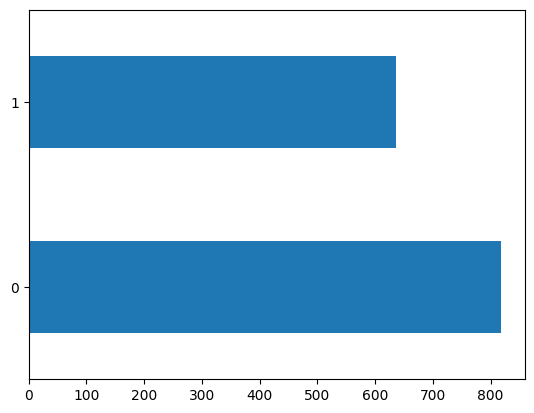

In [6]:
df.Sex.value_counts().plot(kind='barh')

In [7]:
print(df.iloc[1430]['Patient'], df.iloc[1430]['PAN Date'], df.iloc[1430]['PAN Path'])

nan nan /home/12559743/DAVI/todos_pacientes/ZILDA SCHIAVON CAMILLO/ZILDA SCHIAVON CAMILLO- -- - - - 15-09-1961- PX from 29-02-2016 S0 I0aug_cr.jpg


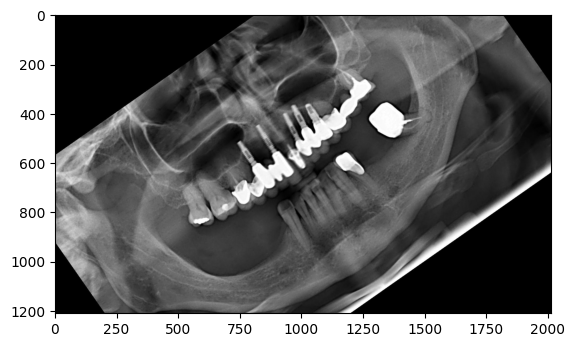

In [8]:
img = plt.imread(df.iloc[1450]['PAN Path'])
plt.imshow(img)

In [9]:
class_names = ['fem', 'mac']

# Criando as variaveis complexas

In [10]:
class Complexity:
    def __init__(self):
        self.bins = 100

    def entropy(self, p):
        histogram = tf.histogram_fixed_width(p, value_range=(p.min(), p.max()), nbins=self.bins)
        prob = histogram / tf.reduce_sum(histogram)
        log_prob = tf.math.log(prob)
        plogp = prob * log_prob
        return tf.reduce_sum(plogp)

    def desiquilibrium(self, p):
        histogram = tf.histogram_fixed_width(p, value_range=(p.min(), p.max()), nbins=self.bins)
        histogram = histogram - self.normal_prob()
        return tf.reduce_sum(tf.square(histogram))

    def complexity(self, p):
        return self.entropy(p) * self.desiquilibrium(p)

    def normal_prob(self):
        return 1.0 / self.bins

    def extract_model_data(model, model_data=None):
        if model_data is None:
            model_data = dict()
        c = Complexity()
        for name, param in model.named_parameters():
            if param.requires_grad:
                # we got a valid parameter to extract
                if name not in model_data.keys():
                    model_data[name] = {'entropy' : list(), 'desiquilibrium' : list(), 'complexity' : list() }
                model_data[name]['entropy'].append(c.entropy(param.data))
                model_data[name]['desiquilibrium'].append(c.desiquilibrium(param.data))
                model_data[name]['complexity'].append(c.complexity(param.data))
        return model_data

# Realizando a separação dos dados

In [11]:
train, val, test = data_separator(df, train_rate=.8, val_rate=.5)
    
print(len(train), len(val), len(test))

1164 145 146


In [12]:
train_list = (list(train['PAN Path']), list(train['Sex']))
val_list = (list(val['PAN Path']), list(val['Sex']))
test_list = (list(test['PAN Path']), list(test['Sex']))

print(len(train), len(val), len(test))

1164 145 146


In [13]:
print(train_list[0][50], train_list[1][50])
path = train_list[0][50]
df[df['PAN Path'] ==path]['Age at PAN']

/home/12559743/DAVI/todos_pacientes/VANDERLEI MICAS/VANDERLEI MICAS- -- - - - 17-06-1966- PX from 19-02-2021 S0 I0_cr.jpg 1


1027    55.0
Name: Age at PAN, dtype: float64

In [14]:
from itertools import repeat

#train
input_shape = (224,224,3)

image_list_train = list(map(load_and_preprocess_image, train_list[0], repeat('jpg'), repeat(input_shape)))
train_dataset = generate_path_dataset(image_list_train, train_list[1]).shuffle(len(image_list_train), seed=42)

#validation

image_list_val = list(map(load_and_preprocess_image, val_list[0], repeat('jpg'), repeat(input_shape)))
val_dataset = generate_path_dataset(image_list_val, val_list[1]).shuffle(len(image_list_val), seed=42)

#test

image_list_test = list(map(load_and_preprocess_image, test_list[0], repeat('jpg'), repeat(input_shape)))
test_dataset = generate_path_dataset(image_list_test, test_list[1]).shuffle(len(image_list_val), seed=42)

2023-12-22 14:13:50.017861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 14:13:50.727633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8000 MB memory:  -> device: 0, name: Quadro P5000, pci bus id: 0000:3b:00.0, compute capability: 6.1


(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (0, 0)]
(135, 224, 3)
0
224
44 45
[(44, 45), (0, 0), (

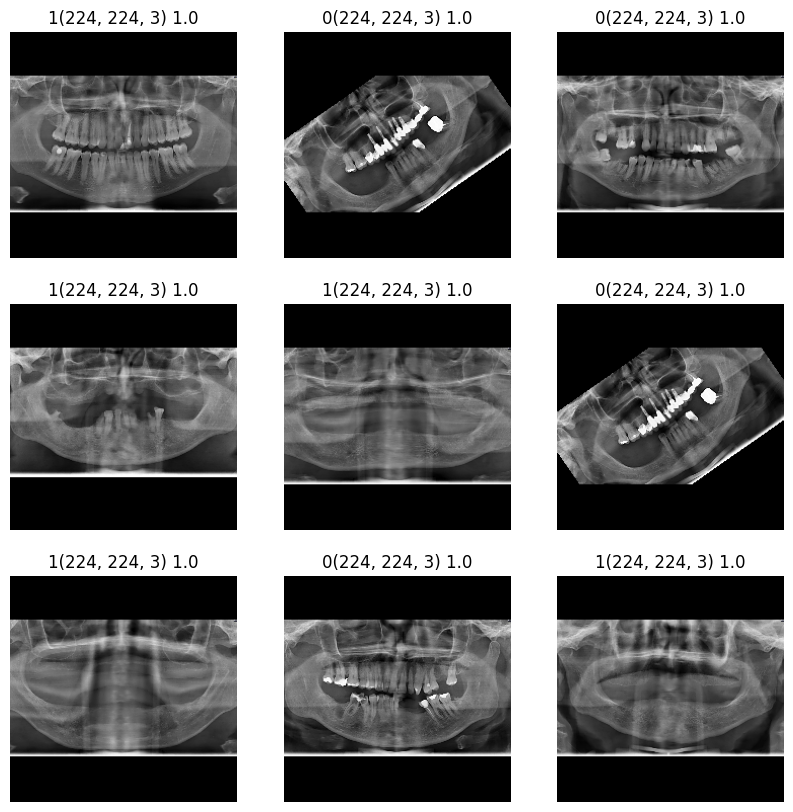

In [15]:
plt.figure(figsize=(10, 10))
i = 0
for pairs in train_dataset:
    ax = plt.subplot(3, 3, i + 1)
    #print('Max',pairs[0].numpy().max(),'Shape', pairs[0].numpy().shape)
    plt.imshow(pairs[0], cmap='gray')
    plt.title(str(pairs[1].numpy()) + str(pairs[0].shape) + ' ' + str(pairs[0].numpy().max()))
    plt.axis("off")
    
    i += 1
    if i == 9:
        break

# Realização do treino da IA

In [49]:
train_data_used = train_dataset
val_data_used = val_dataset

BUFFER_SIZE = len(train_data_used)
BATCH_SIZE = 4


train_data = train_data_used.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data = val_data_used.cache().shuffle(len(val_data_used)).batch(BATCH_SIZE)

EXP_PATH = r'/home/12559743/DAVI/IC/Codes'
EXP_NAME = 'classification_sex_augmented_data'

checkpoint_path = os.path.join(EXP_PATH, EXP_NAME + '/cp-{epoch:04d}.ckpt')

    
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor = 'val_accuracy',
                                                     save_best_only = True,
                                                     save_weights_only=True,
                                                     mode='max',
                                                     verbose=1)

log_dir = EXP_PATH+EXP_NAME+'/log/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tf.keras.backend.clear_session()


train_acc = []
val_acc = []
train_loss = []
val_loss = []

EPOCHS = 300

efficient = start_model(choice_model='efficientnetv2', choice_opt='Adam', num_classes=1, loss='mean_absolute_error',
                        pred_acticvation='sigmoid', metrics= ['accuracy', 'mae'])
in_model_history = efficient.fit(train_data,validation_data=val_data, epochs=EPOCHS,
                                 callbacks=[cp_callback, tb_callback]);


Epoch 1/300


2023-11-06 16:36:49.579011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-06 16:36:50.641616: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-06 16:36:50.684861: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-06 16:36:50.818985: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

291/291 [==============================] - ETA: 0s - loss: 0.2960 - accuracy: 0.7234 - mae: 0.2960
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to /home/12559743/DAVI/IC/Codes/classification_sex_augmented_data/cp-0001.ckpt


2023-11-06 16:38:18.981814: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-06 16:38:19.012547: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


291/291 [==============================] - 143s 369ms/step - loss: 0.2960 - accuracy: 0.7234 - mae: 0.2960 - val_loss: 0.4976 - val_accuracy: 0.4000 - val_mae: 0.4976
Epoch 2/300
291/291 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.7320 - mae: 0.2722
Epoch 2: val_accuracy improved from 0.40000 to 0.70345, saving model to /home/12559743/DAVI/IC/Codes/classification_sex_augmented_data/cp-0002.ckpt
291/291 [==============================] - 104s 357ms/step - loss: 0.2722 - accuracy: 0.7320 - mae: 0.2722 - val_loss: 0.2965 - val_accuracy: 0.7034 - val_mae: 0.2965
Epoch 3/300
291/291 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.7414 - mae: 0.2590
Epoch 3: val_accuracy improved from 0.70345 to 0.71724, saving model to /home/12559743/DAVI/IC/Codes/classification_sex_augmented_data/cp-0003.ckpt
291/291 [==============================] - 103s 354ms/step - loss: 0.2590 - accuracy: 0.7414 - mae: 0.2590 - val_loss: 0.2826 - val_accuracy: 0.7172

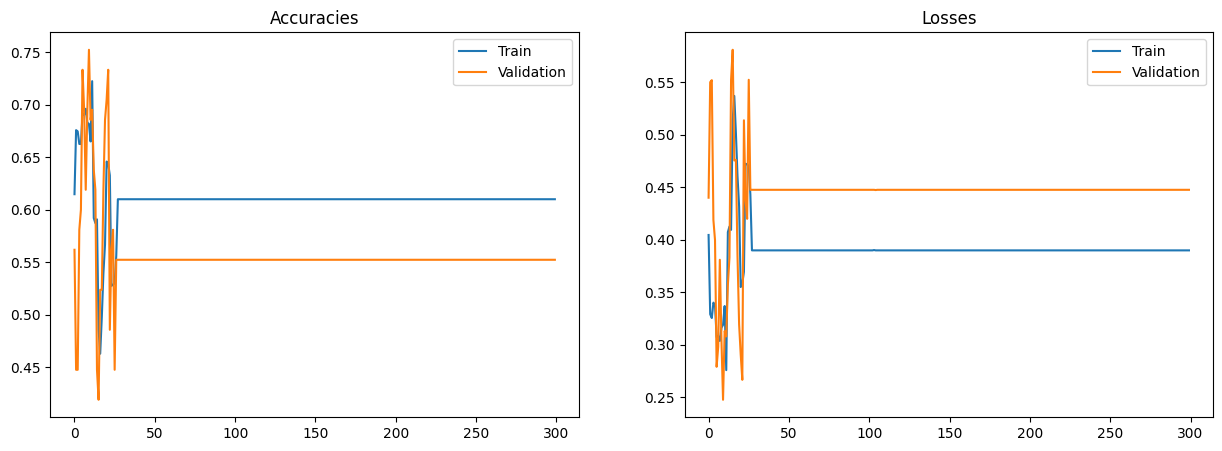

In [16]:
plot_model_history(in_model_history.history['accuracy'], in_model_history.history['val_accuracy'],
                  in_model_history.history['loss'], in_model_history.history['val_loss'])

In [15]:
efficient_reload = start_model(choice_model='efficientnetv2', choice_opt='Adam', num_classes=1, loss='mean_absolute_error',
                        pred_acticvation='sigmoid', metrics= ['accuracy', 'mae'])
experiment_path = r'/home/12559743/DAVI/IC/Codes/'
experiment_name = 'classification_sex_create_no_shuffle_new/'
 #/home/12559743/DAVI/IC/Codes/classification_sex_create_no_shuffle_new/cp-0033.ckpt
best_cp = 'cp-0150.ckpt'

checkpoint_path = os.path.join(experiment_path, experiment_name)
path_weight = os.path.join(checkpoint_path, best_cp)
efficient_reload.load_weights(path_weight)

ValueError: Received incompatible tensor with shape (640,) when attempting to restore variable with shape (680,) and name layer_with_weights-1/bias/.ATTRIBUTES/VARIABLE_VALUE.

In [16]:
model = start_model(choice_model='efficientnetv2', choice_opt='Adam', num_classes=1, loss='mean_absolute_error',
                        pred_acticvation='sigmoid', metrics= ['accuracy', 'mae'])

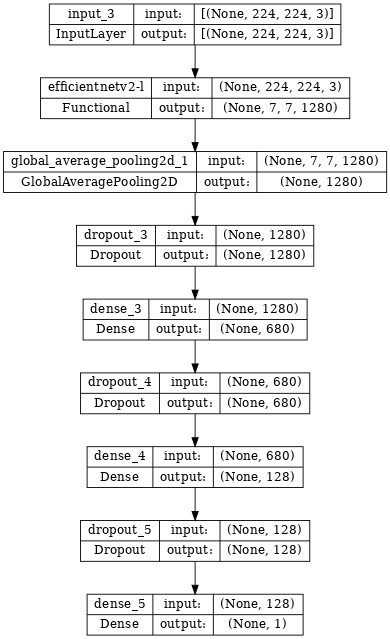

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi = 64)

1/1 [==============================] - 0s 435ms/step
1 0
1/1 [==============================] - 0s 25ms/step
1 1
1/1 [==============================] - 0s 25ms/step
1 1
1/1 [==============================] - 0s 26ms/step
1 1
1/1 [==============================] - 0s 26ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 26ms/step
1 0
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 26ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 0
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 28ms/step
1 0
1/1 [==============================] - 0s 25ms/step
1 1
1/1 [==============================] - 0s 24ms/

1/1 [==============================] - 0s 24ms/step
1 0
1/1 [==============================] - 0s 31ms/step
1 0
1/1 [==============================] - 0s 24ms/step
1 0
1/1 [==============================] - 0s 24ms/step
1 0
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 21ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 26ms/step
1 0
1/1 [==============================] - 0s 23ms/step
1 0
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 0
1/1 [==============================] - 0s 25ms/s

1/1 [==============================] - 0s 37ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 23ms/step
1 0
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 27ms/step
1 0
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 26ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 21ms/step
1 0
1/1 [==============================] - 0s 38ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 23ms/s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


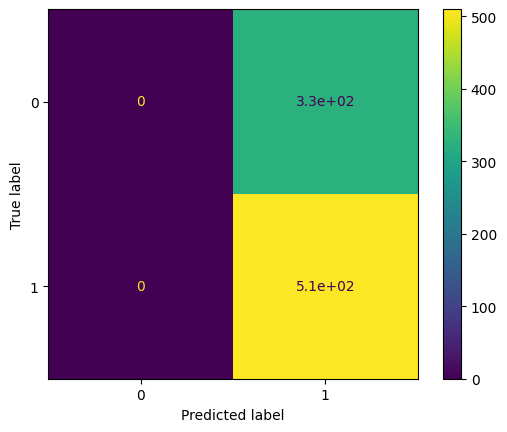

In [19]:
# for train dataset
model = efficient_reload
y_true, y_pred = get_dataset_prediction(train_dataset, model)
evaluate_prediction(y_true, y_pred)

1/1 [==============================] - 0s 27ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 0
1/1 [==============================] - 0s 28ms/step
1 1
1/1 [==============================] - 0s 25ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 28ms/step
1 0
1/1 [==============================] - 0s 26ms/step
1 0
1/1 [==============================] - 0s 29ms/step
1 0
1/1 [==============================] - 0s 21ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 0
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 0
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 21ms/step
1 0
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 36ms/s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


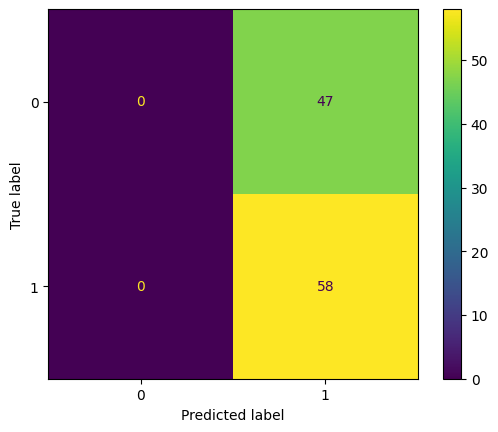

In [20]:
#for val dataset
y_true, y_pred = get_dataset_prediction(val_dataset, model)
evaluate_prediction(y_true, y_pred)

1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 28ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 0
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 1
1/1 [==============================] - 0s 21ms/step
1 1
1/1 [==============================] - 0s 21ms/step
1 1
1/1 [==============================] - 0s 23ms/step
1 1
1/1 [==============================] - 0s 24ms/step
1 1
1/1 [==============================] - 0s 22ms/step
1 0
1/1 [==============================] - 0s 23ms/s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


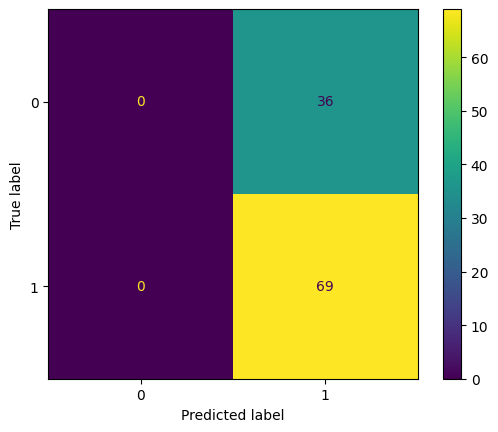

In [21]:
# for test dataset
y_true, y_pred = get_dataset_prediction(test_dataset, model)
evaluate_prediction(y_true, y_pred)


In [141]:
drop_prob = 0.2
model = tf.keras.Sequential([
    tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=input_size,
                                               include_top=False, weights='imagenet')
    tf.keras.layers.GlobalAveragePooling2D()
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1280, activation='relu'),
    tf.keras.layers.Dropout(drop_prob),
    
    tf.keras.layers.Dense(640, activation='relu'),
    tf.keras.layers.Dropout(drop_prob),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(drop_prob),
    
    tf.keras.layers.Dense(1, activation='relu'),
])
])

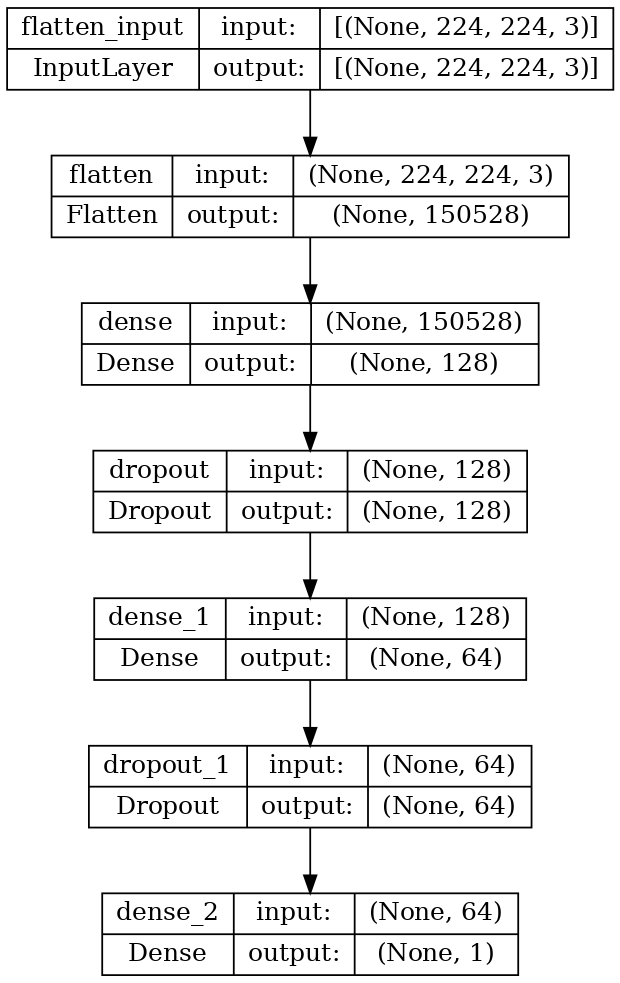

In [142]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi = 64)

In [143]:
model.compile(optimizer ='adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy', 'mae'])

In [144]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,276,033
Trainable params: 19,276,033
No

In [19]:
exp_path= r'/home/12559743/DAVI/IC/Codes'
exp_name = 'classification_Complexity_efficientNet2'

model_data = None
metric_value=[]


checkpoint_path = os.path.join(exp_path, exp_name + '/cp-{epoch:04d}.ckpt')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor = 'val_accuracy',
                                                     save_weights_only=True,
                                                     save_best_only=True,
                                                     mode='max',
                                                     verbose=1)

log_dir = exp_path+exp_name+'/log/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [100]:
class ComplexityCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch):
        complexity_parameter = Complexity.extract_model_data(self.model, model_data=None)
        self.history.append({'epoch': epoch, 'complexity_metrics': complexity_metrics})

In [130]:
class SaveWeightsCallbacks(keras.callbacks.Callback):
    def __init__(self):
        self.weights_per_epoch = []
        
    def on_epoch_end(self, epoch, Logs = None):
        weights = self.model.get_weights() #pega os pesos  
        self.weights_per_epoch.append(weights) #salva os pesos

In [131]:
train_data_used = train_dataset
val_data_used = val_dataset

weigths = SaveWeightsCallbacks()

BUFFER_SIZE = len(train_data_used)
BATCH_SIZE = 4


tf.keras.backend.clear_session()


train_acc = []
val_acc = []
train_loss = []
val_loss = []

train_data = train_data_used.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data = val_data_used.cache().shuffle(len(val_data_used)).batch(BATCH_SIZE)


history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[weigths])

Epoch 1/20
291/291 [==============================] - 4s 12ms/step - loss: 2.1285 - accuracy: 0.7053 - mae: 0.2972 - val_loss: 1.0458 - val_accuracy: 0.6414 - val_mae: 0.3361
Epoch 2/20
291/291 [==============================] - 3s 11ms/step - loss: 0.5250 - accuracy: 0.7904 - mae: 0.2387 - val_loss: 0.4037 - val_accuracy: 0.8000 - val_mae: 0.2163
Epoch 3/20
291/291 [==============================] - 3s 11ms/step - loss: 0.5747 - accuracy: 0.7723 - mae: 0.2590 - val_loss: 0.3389 - val_accuracy: 0.8552 - val_mae: 0.2482
Epoch 4/20
291/291 [==============================] - 3s 11ms/step - loss: 0.4481 - accuracy: 0.7852 - mae: 0.2546 - val_loss: 0.3846 - val_accuracy: 0.7724 - val_mae: 0.2775
Epoch 5/20
291/291 [==============================] - 3s 11ms/step - loss: 0.4821 - accuracy: 0.7878 - mae: 0.2465 - val_loss: 0.3036 - val_accuracy: 0.8621 - val_mae: 0.2177
Epoch 6/20
291/291 [==============================] - 3s 11ms/step - loss: 0.4061 - accuracy: 0.7981 - mae: 0.2487 - val_loss

In [ ]:
weights_list = weigths.weights_per_epoch
print(type(weights_list))
weights_list_np = np.array(weights_list)
print(weights_list_np.shape)
print(weights_list[0][])

In [169]:
list_reshap1 = tf.reshape(weights_list[0][4], [64]).numpy()
list_reshap1

array([-0.06251973,  0.17327029, -0.01880881,  0.20366554, -0.09897202,
       -0.00618759,  0.20918478, -0.27018377,  0.00645247, -0.2796162 ,
        0.06013569, -0.1642655 ,  0.0707421 ,  0.04193464, -0.26952252,
       -0.217937  , -0.13339992, -0.1085659 ,  0.09569646, -0.17178118,
       -0.18479173,  0.23077607,  0.29940432, -0.07469488,  0.02613921,
        0.09874492,  0.09780601,  0.02371943,  0.21541716, -0.13396482,
        0.14096904,  0.16158472,  0.11196342, -0.00740108, -0.21965599,
       -0.10002584, -0.0744429 , -0.04136096,  0.09538329, -0.09894536,
        0.27651006, -0.24592233, -0.04736399, -0.05708272, -0.29444143,
       -0.06333851, -0.01526713, -0.19958802,  0.09545458, -0.00189467,
        0.23333196, -0.12033188,  0.13490455,  0.09867041, -0.21016464,
        0.28492367, -0.03789294,  0.21389061,  0.01562598,  0.05193716,
       -0.00418212, -0.21171716, -0.10022648, -0.16680679], dtype=float32)

In [185]:
list_weights = []
for i in range(20):
    for j in range(5):
        list_temp = []
        if j==0:
            list_reshap = tf.reshape(weights_list[i][j], [19267584]).numpy().tolist()
        elif j==2:
            list_reshap = tf.reshape(weights_list[i][j], [8192]).numpy().tolist()
        elif j == 4:
            list_reshap = tf.reshape(weights_list[i][j], [64]).numpy().tolist()
        else:
            list_reshap = weights_list[i][j].tolist()
        list_temp.append(list_reshap)
    list_weights.append(list_temp)
list_weights

[[[-0.06251972913742065,
   0.17327028512954712,
   -0.01880880631506443,
   0.20366553962230682,
   -0.09897202253341675,
   -0.00618758937343955,
   0.20918478071689606,
   -0.2701837718486786,
   0.006452474277466536,
   -0.27961620688438416,
   0.06013568863272667,
   -0.1642654985189438,
   0.07074210047721863,
   0.04193463921546936,
   -0.2695225179195404,
   -0.21793699264526367,
   -0.13339991867542267,
   -0.10856589674949646,
   0.09569645673036575,
   -0.17178118228912354,
   -0.18479172885417938,
   0.23077607154846191,
   0.2994043231010437,
   -0.07469487935304642,
   0.02613920532166958,
   0.09874492138624191,
   0.09780600666999817,
   0.023719429969787598,
   0.21541716158390045,
   -0.13396482169628143,
   0.14096903800964355,
   0.16158472001552582,
   0.1119634211063385,
   -0.007401082664728165,
   -0.21965599060058594,
   -0.10002584010362625,
   -0.07444290071725845,
   -0.04136095568537712,
   0.09538328647613525,
   -0.09894535690546036,
   0.2765100598335266

In [187]:
list_weights_np = np.array(list_weights)

array_concat = np.concatenate(list_weights, axis = 0)

weights_list_final = array_concat.tolist()

print(len(weights_list_final))

19


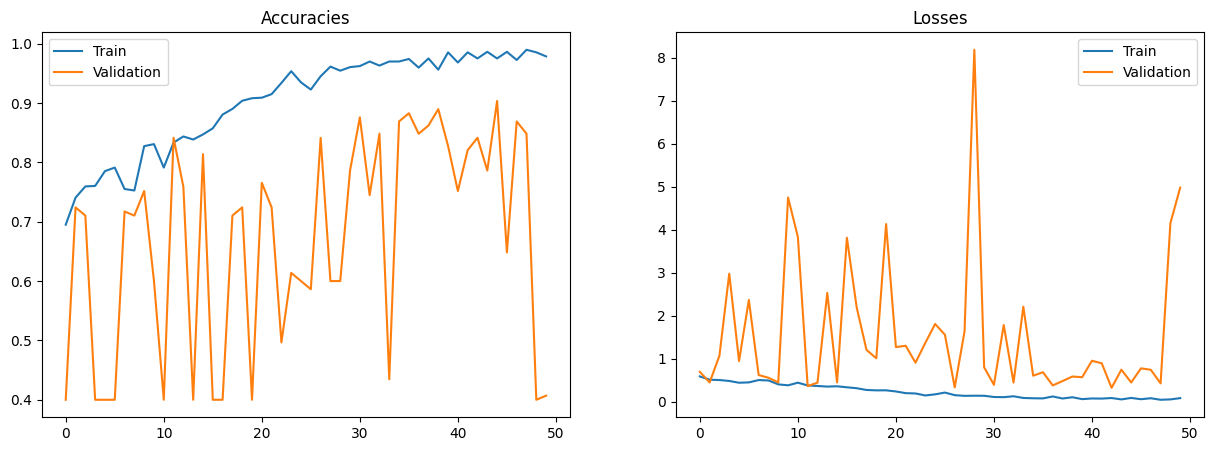

In [41]:
plot_model_history(history.history['accuracy'], history.history['val_accuracy'],
                  history.history['loss'], history.history['val_loss'])

In [51]:
class Complexity:
    def __init__(self):
        self.bins = 100
        
    def entropy(self,p):
        histogram = tf.histogram_fixed_width(np.array(p), self.bins, dtype=tf.int32)
        prob = tf.cast(histogram, tf.float32) / tf.reduce_sum(histogram)
        log_prob = tf.math.log(prob + 10e-10)
        plogp = prob*log_prob
        plogp= tf.where(tf.math.is_nan(plogp), tf.zeros_like(plogp), plogp)
        entropy = -tf.reduce_sum(plogp).numpy()
        return entropy
    
    def desiquilibrium (self, p):
        histogram = tf.histogram_fixed_width(p.numpy(), self.bins, dtype=tf.int32)
        histogram_diff = histogram - self.normal_prob()
        desiquilibrium = tf.reduce_sum(tf.square(histogram_diff)).numpy()
        return desiquilibrium
    
    def complexity(self, p):
        return self.entropy(p) - self.desiquilibrium(p)
    
    def normal_prob(self):
        return 1/self.bins

In [24]:
efficient_reload = model

experiment_path = r'/home/12559743/DAVI/IC/Codes/'
experiment_name = 'classification_sex_data_aug/'

best_cp = 'cp-0014.ckpt'

checkpoint_path = os.path.join(experiment_path, experiment_name)
path_weight = os.path.join(checkpoint_path, best_cp)
efficient_reload.load_weights(path_weight)

2023-11-07 15:10:18.047680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step
0 1
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 33ms/step
0 0
1/1 [==============================] - 0s 41ms/step
0 0
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 34ms/step
0 0
1/1 [==============================] - 0s 33ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 33ms/step
1 1
1/1 [==============================] - 0s 35ms/step
1 1
1/1 [==============================] - 0s 33ms/step
0 0
1/1 [==============================] - 0s 33ms/step
0 0
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 31ms/ste

1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 31ms/step
0 1
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 35ms/step
0 0
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 30ms/step
0 1
1/1 [==============================] - 0s 30ms/step
1 0
1/1 [==============================] - 0s 30ms/step
0 1
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 30ms/step
1 1
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 27ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 33ms/step
0 0
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 30ms/step
1 1
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 33ms/step
1 1
1/1 [==============================] - 0s 33ms/step
1 0
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 35ms/step
0 1
1/1 [==============================] - 0s 30ms/s

1/1 [==============================] - 0s 29ms/step
0 0
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 32ms/step
0 1
1/1 [==============================] - 0s 34ms/step
0 0
1/1 [==============================] - 0s 30ms/step
1 1
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 30ms/step
1 1
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 31ms/step
0 1
1/1 [==============================] - 0s 30ms/step
0 0
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 31ms/step
0 1
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 31ms/s

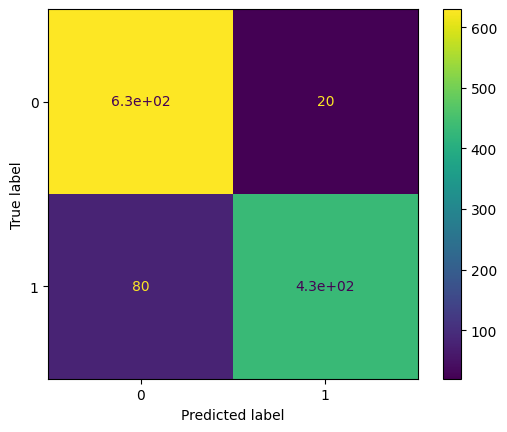

In [25]:
# for train dataset
#model2 = efficient_reload
y_true, y_pred = get_dataset_prediction(train_dataset, model)
evaluate_prediction(y_true, y_pred)

1/1 [==============================] - 0s 34ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 38ms/step
1 1
1/1 [==============================] - 0s 36ms/step
1 1
1/1 [==============================] - 0s 36ms/step
0 0
1/1 [==============================] - 0s 46ms/step
1 1
1/1 [==============================] - 0s 36ms/step
1 1
1/1 [==============================] - 0s 34ms/step
0 1
1/1 [==============================] - 0s 35ms/step
1 0
1/1 [==============================] - 0s 35ms/step
0 0
1/1 [==============================] - 0s 35ms/step
0 0
1/1 [==============================] - 0s 36ms/step
0 0
1/1 [==============================] - 0s 35ms/step
1 0
1/1 [==============================] - 0s 35ms/step
1 1
1/1 [==============================] - 0s 36ms/step
1 1
1/1 [==============================] - 0s 40ms/step
1 1
1/1 [==============================] - 0s 36ms/step
0 0
1/1 [==============================] - 0s 36ms/s

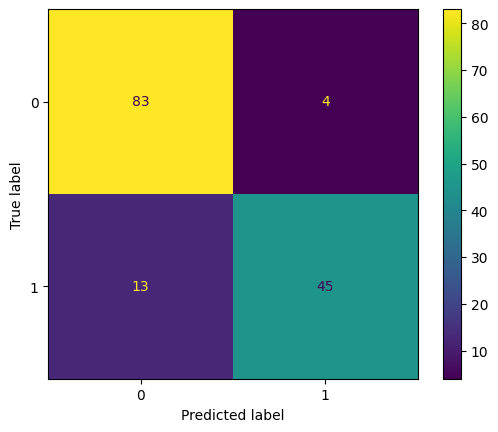

In [26]:
y_true, y_pred = get_dataset_prediction(val_dataset, model)
evaluate_prediction(y_true, y_pred)

1/1 [==============================] - 0s 32ms/step
0 0
1/1 [==============================] - 0s 34ms/step
1 1
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 32ms/step
1 1
1/1 [==============================] - 0s 31ms/step
1 1
1/1 [==============================] - 0s 30ms/step
1 0
1/1 [==============================] - 0s 31ms/step
0 0
1/1 [==============================] - 0s 31ms/step
0 1
1/1 [==============================] - 0s 30ms/step
1 0
1/1 [==============================] - 0s 31ms/step
1 0
1/1 [==============================] - 0s 30ms/step
1 1
1/1 [==============================] - 0s 33ms/step
1 1
1/1 [==============================] - 0s 36ms/step
1 0
1/1 [==============================] - 0s 33ms/step
0 1
1/1 [==============================] - 0s 33ms/step
1 1
1/1 [==============================] - 0s 34ms/step
1 1
1/1 [==============================] - 0s 32ms/s

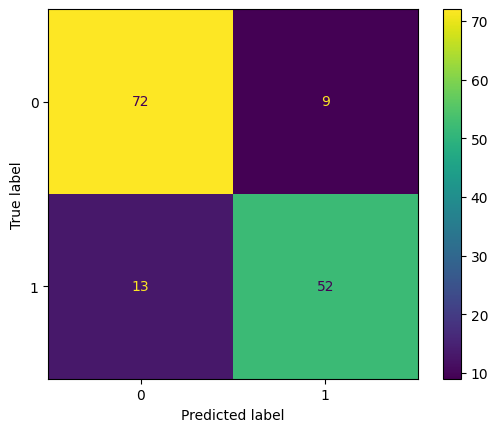

In [27]:
y_true, y_pred = get_dataset_prediction(test_dataset, model)
evaluate_prediction(y_true, y_pred)

In [23]:
test_dataset_norm = np.expand_dims(test_dataset, axis=0)